In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

from solardatatools import DataHandler
from solardatatools.signal_decompositions import tl1_l2d2p365 as cvx_sd
from solardatatools.signal_decompositions_l2norm import tl1_l2d2p365 as cvx_sd_l2norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

# New updates:
## - Scale daily energy by max
## - Add periodicity constraint for daily energy decompositions

# Save data in dict

In [4]:
path = "./cassandra/*.csv"

cassandra_data = {}

for fname in glob.glob(path):
    print(fname)
    df = pd.read_csv(fname)
    # data = df["meas_val_f"] # ac power
    dh = DataHandler(df, convert_to_ts=True)
    dh.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True)#, solver="MOSEK")
    data = dh.filled_data_matrix
    tc = np.linalg.norm(data[:-2] - 2 * data[1:-1] + data[2:], ord=1, axis=0)
    # Normalize such that the maximum value is equal to one
    tc /= np.nanmax(tc)
    tc = 1 - tc

    # Calculate the daily energy
    de = np.sum(data, axis=0)
    de /= np.nanmax(de) # ADDED SCALING

    cassandra_data[f"{fname}_tc"] = tc
    cassandra_data[f"{fname}_de"] = de

./cassandra/TAAI01129193.csv
total time: 86.26 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              9.52s
Cleaning                   60.29s
Filtering/Summarizing      16.46s
    Data quality           0.41s
    Clear day detect       2.12s
    Clipping detect        0.12s
    Capacity change detect 13.80s

./cassandra/TACHC1022158.csv
total time: 27.26 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.62s
Cleaning                   16.82s
Filtering/Summarizing      5.82s
    Data quality           0.26s
    Clear day detect       0.93s
    Clipping detect        0.14s
    Capacity change detect 4.49s

./cassandra/TACIC1066981.csv
total time: 35.30 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              7.01s
Cleaning                   17.62s
Filtering/Summarizing      10.67s
    Data quality           0.31s
    C

# Testing these weights (TC)

In [28]:
np.log10(204697)

5.311111477772457

MAE s_hat  (OSD,CVX)   1.10e-03


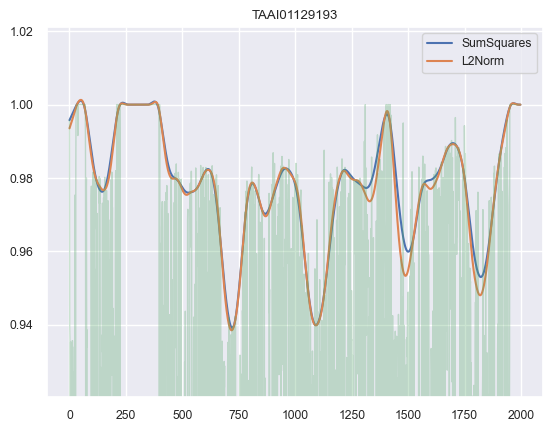

MAE s_hat  (OSD,CVX)   6.60e-04


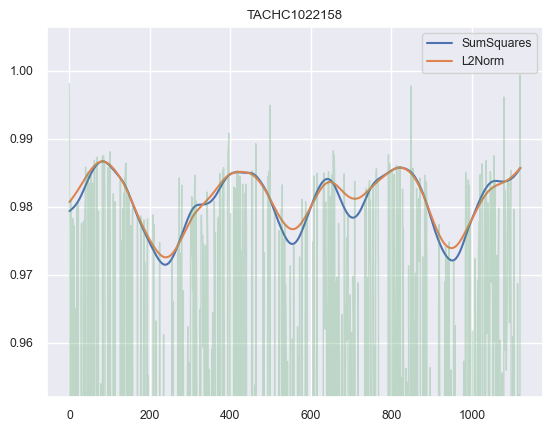

MAE s_hat  (OSD,CVX)   6.11e-04


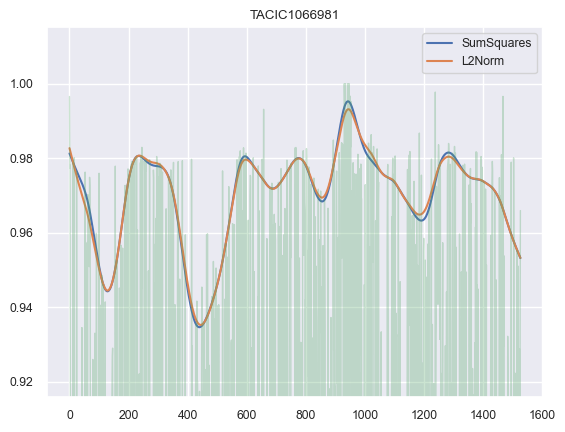

MAE s_hat  (OSD,CVX)   9.47e-04


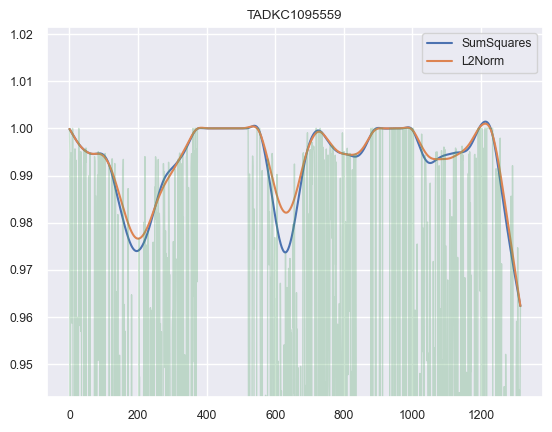

MAE s_hat  (OSD,CVX)   4.87e-04


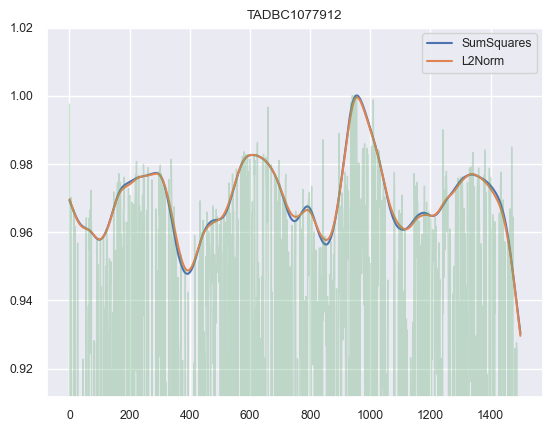

MAE s_hat  (OSD,CVX)   1.46e-03


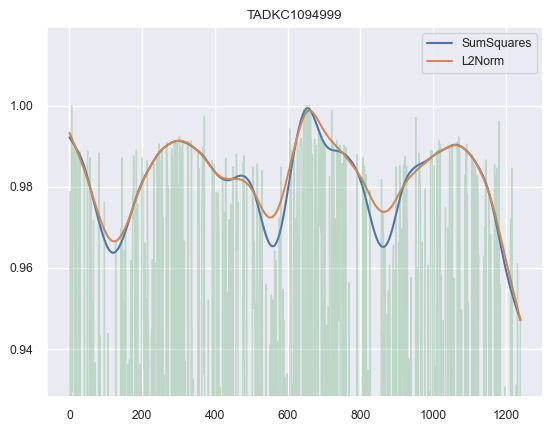

In [26]:
for fname in glob.glob(path):
    
    tc = cassandra_data[f"{fname}_tc"] 
    # cvx_ss = cvx_sd(tc, tau=0.9, yearly_periodic=False,
    #                 c1=3352924.15, solver="OSQP")
    
    cvx_ss = cvx_sd(tc, tau=0.9, yearly_periodic=False,
                c1=2.5e6, verbose=False)#, solver="MOSEK")

    cvx_l2n = cvx_sd_l2norm(tc, tau=0.9, c1=1e3,
                            yearly_periodic=False)#, solver="MOSEK")

    print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss, cvx_l2n):.2e}')

    f, (ax1) = plt.subplots(1, 1, sharex=True)
    ax1.plot(cvx_ss, label="SumSquares")
    ax1.plot(cvx_l2n, label="L2Norm")
    ax1.plot(tc, alpha=0.3, linewidth=1)
    ax1.set_ylim(min(cvx_ss)*0.98, max(cvx_ss)*1.02)
    ax1.set_title(fname[12:-4])

    ax1.legend()
    plt.show()

MAE s_hat  (OSD,CVX)   2.11e-03


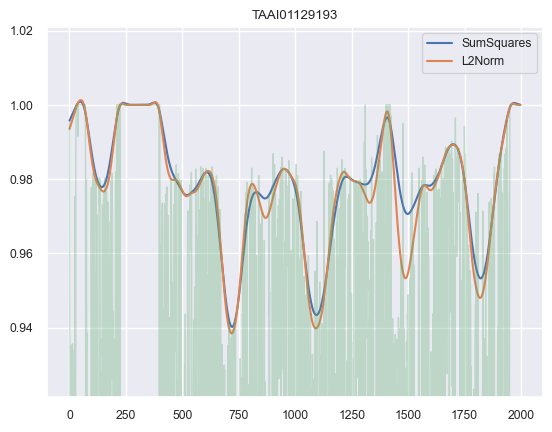

MAE s_hat  (OSD,CVX)   6.50e-04


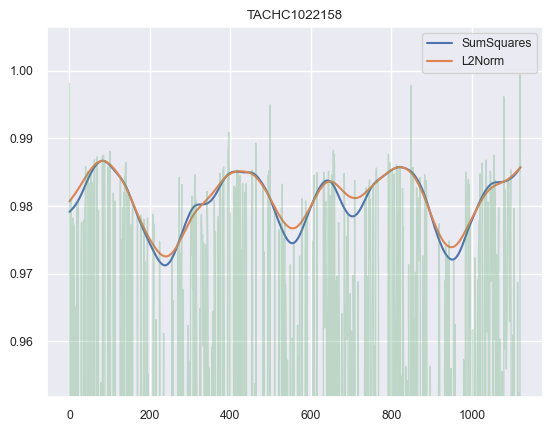

MAE s_hat  (OSD,CVX)   3.48e-04


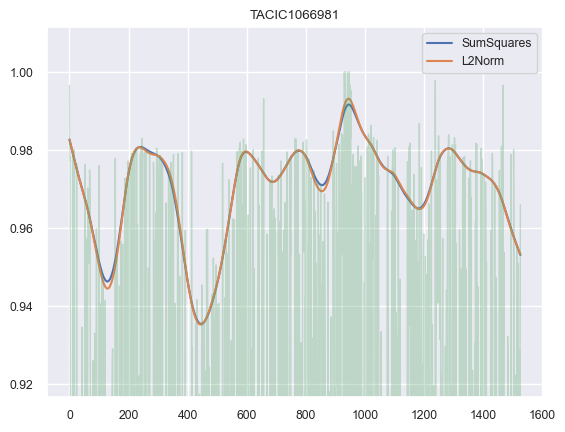

MAE s_hat  (OSD,CVX)   3.54e-04


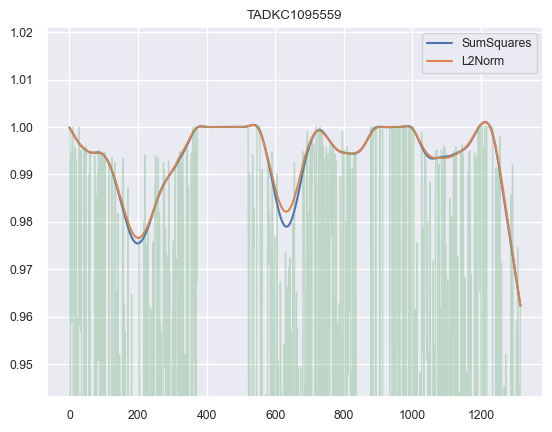

MAE s_hat  (OSD,CVX)   3.40e-04


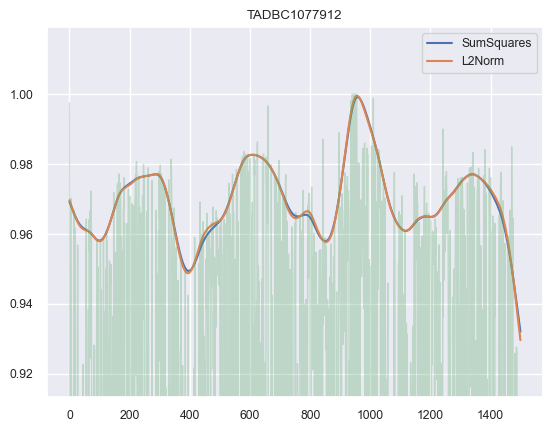

MAE s_hat  (OSD,CVX)   5.57e-04


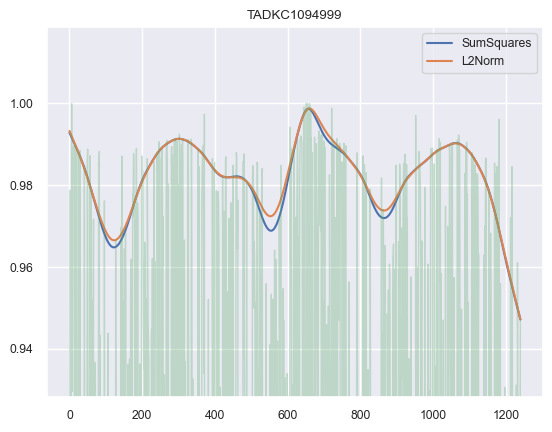

In [27]:
for fname in glob.glob(path):
    
    tc = cassandra_data[f"{fname}_tc"] 
    # cvx_ss = cvx_sd(tc, tau=0.9, yearly_periodic=False,
    #                 c1=3352924.15, solver="OSQP")
    
    cvx_ss = cvx_sd(tc, tau=0.9, yearly_periodic=False,
                c1=2.5e6, verbose=False, solver="MOSEK")

    cvx_l2n = cvx_sd_l2norm(tc, tau=0.9, c1=1e3,
                            yearly_periodic=False, solver="MOSEK")

    print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss, cvx_l2n):.2e}')

    f, (ax1) = plt.subplots(1, 1, sharex=True)
    ax1.plot(cvx_ss, label="SumSquares")
    ax1.plot(cvx_l2n, label="L2Norm")
    ax1.plot(tc, alpha=0.3, linewidth=1)
    ax1.set_ylim(min(cvx_ss)*0.98, max(cvx_ss)*1.02)
    ax1.set_title(fname[12:-4])

    ax1.legend()
    plt.show()

MAE s_hat  (OSD,CVX)   2.74e-03


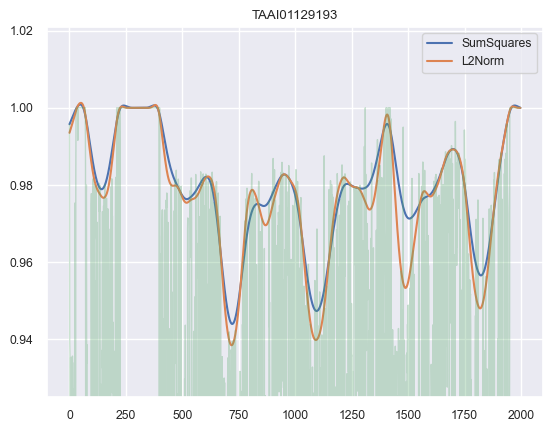

MAE s_hat  (OSD,CVX)   4.78e-04


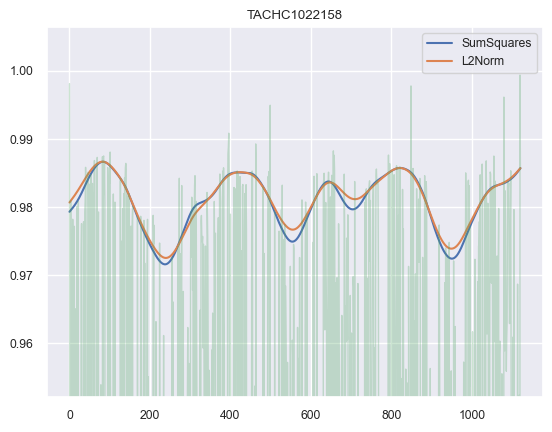

MAE s_hat  (OSD,CVX)   7.16e-04


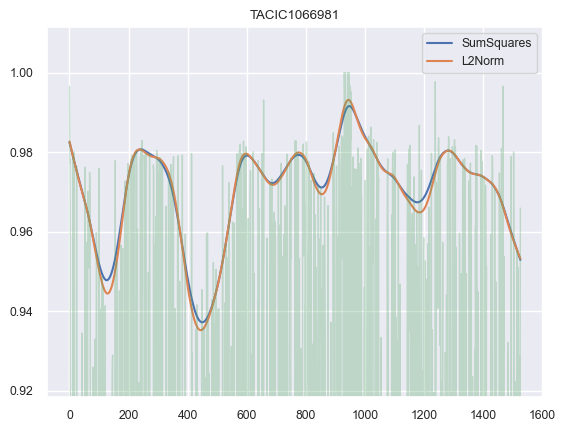

MAE s_hat  (OSD,CVX)   1.32e-05


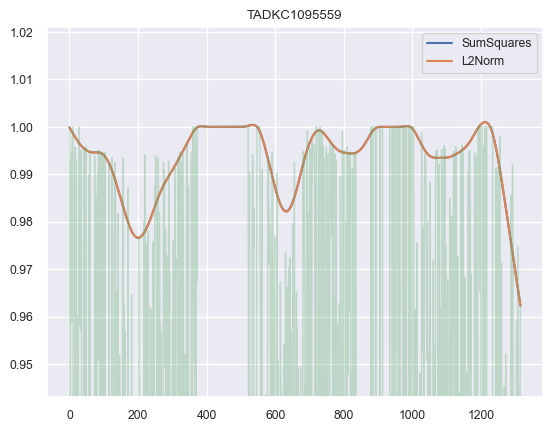

MAE s_hat  (OSD,CVX)   6.68e-04


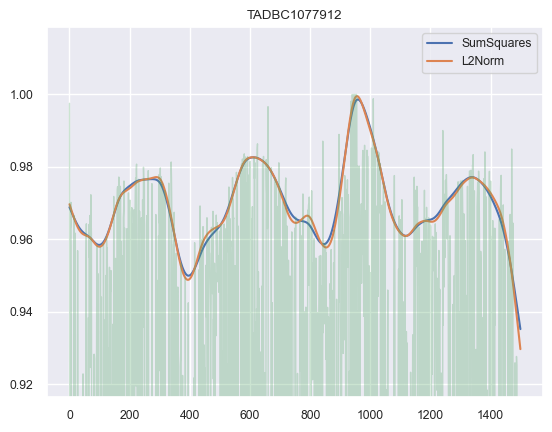

MAE s_hat  (OSD,CVX)   1.19e-04


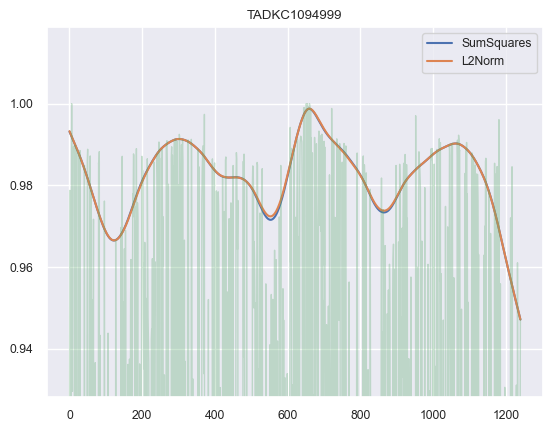

In [7]:
for fname in glob.glob(path):
    
    tc = cassandra_data[f"{fname}_tc"] 
    cvx_ss = cvx_sd(tc, tau=0.9, yearly_periodic=False,
                    c1=3352924.15, solver="MOSEK")

    cvx_l2n = cvx_sd_l2norm(tc, tau=0.9, c1=1e3,
                            yearly_periodic=False, solver="MOSEK")

    print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss, cvx_l2n):.2e}')

    f, (ax1) = plt.subplots(1, 1, sharex=True)
    ax1.plot(cvx_ss, label="SumSquares")
    ax1.plot(cvx_l2n, label="L2Norm")
    ax1.plot(tc, alpha=0.3, linewidth=1)
    ax1.set_ylim(min(cvx_ss)*0.98, max(cvx_ss)*1.02)
    ax1.set_title(fname[12:-4])

    ax1.legend()
    plt.show()

# Weight opt with OSQP

In [11]:
results = {}

In [14]:
weight_iter = np.logspace(5.3, 6.47, 60)

def run(sig):
    mae_list = []
    try:
        cvx_l2n = cvx_sd_l2norm(sig, tau=0.9, c1=1e3, yearly_periodic=False)#, verbose=True)
    except:
        return 0, 0, 0
    
    for w in tqdm(weight_iter):
        try:
            res = cvx_sd(sig, tau=0.9, c1=w, yearly_periodic=False, solver="OSQP")
            mae_list.append(mae(cvx_l2n, res))
        except:
            mae_list.append(1)
            
    return weight_iter[np.argmin(mae_list)], np.min(mae_list), mae_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:10<00:00,  1.18s/it]


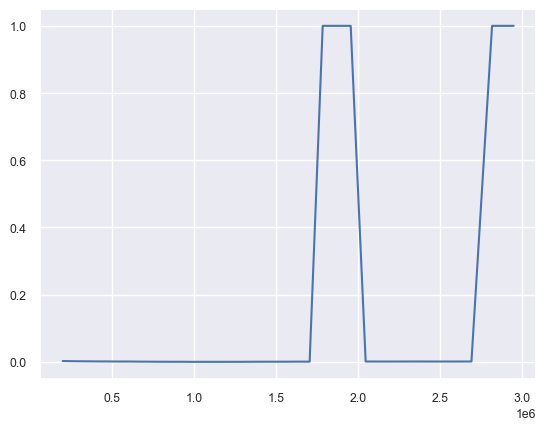

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:33<00:00,  1.79it/s]


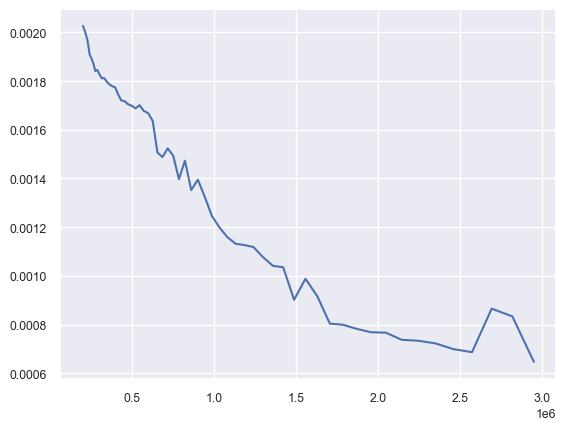

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:53<00:00,  1.12it/s]


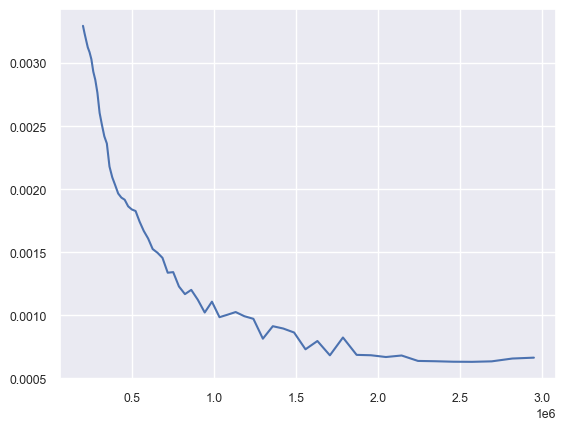

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:39<00:00,  1.51it/s]


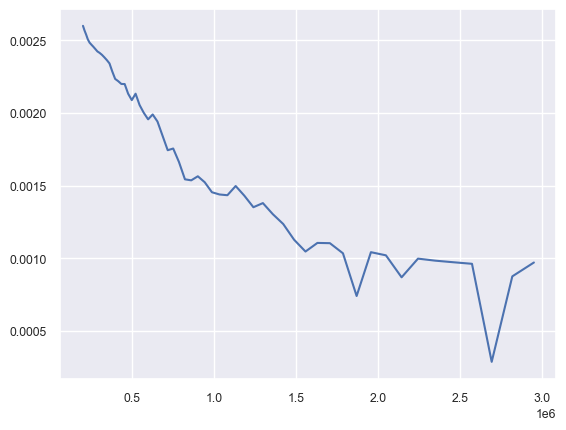

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:51<00:00,  1.17it/s]


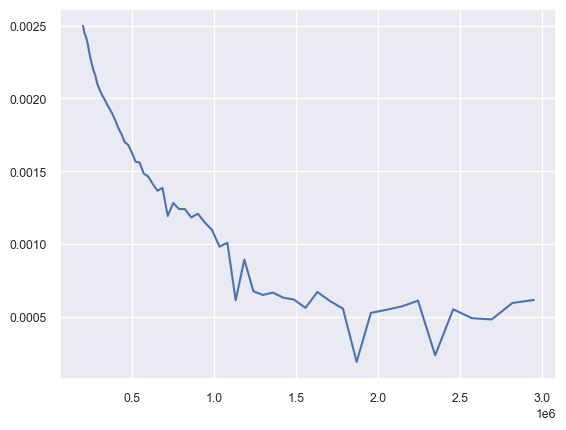

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:42<00:00,  1.41it/s]


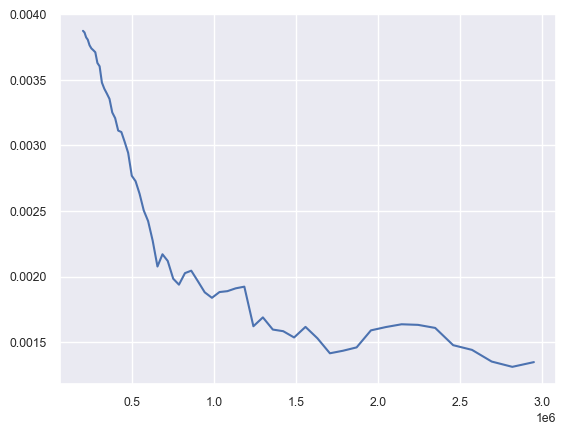

In [15]:
for fname in glob.glob(path):
    

    r = run(cassandra_data[f"{fname}_tc"])
    results[f"{fname}_weight_min_tc"] =  r[0]
    results[f"{fname}_mae_min_tc"] = r[1]
    results[f"{fname}_mae_list_tc"] = r[2]
    try:
        plt.plot(weight_iter, results[f"{fname}_mae_list_tc"])
        plt.show()
    except:
        print(f"{fname} bad SD")

In [16]:
weights_mosek_osqp = []
for fname in glob.glob(path):
    weights_mosek_osqp.append(results[f"{fname}_weight_min_tc"])
    print(results[f"{fname}_weight_min_tc"])

1131251.9010379484
2951209.226666384
2573406.9799408307
2693636.467395222
1869368.4783314334
2819483.0724552753


In [17]:
w_med_mosek_osqp = np.median(weights_mosek_osqp)
w_med_mosek_osqp

2633521.7236680263